In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [10]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        
        if "P" == node[0]:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [11]:
# Define positions manually for x and y positions
pos = {}

for i in range(6):
    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1, 0)          # Final position x
        pos[f'P_FP_y{i}'] = (i * 3, 0)              # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1, -1)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1, -1)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3, -1)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 3)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 3)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 2)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 2)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 2)              # Initial position y
    else:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1, -1)         # Final position x
        pos[f'P_FP_y{i}'] = (i * 3, -1)             # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1, -2)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1, -2)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3, -2)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 4)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 4)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 3)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 3)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 3)              # Initial position y


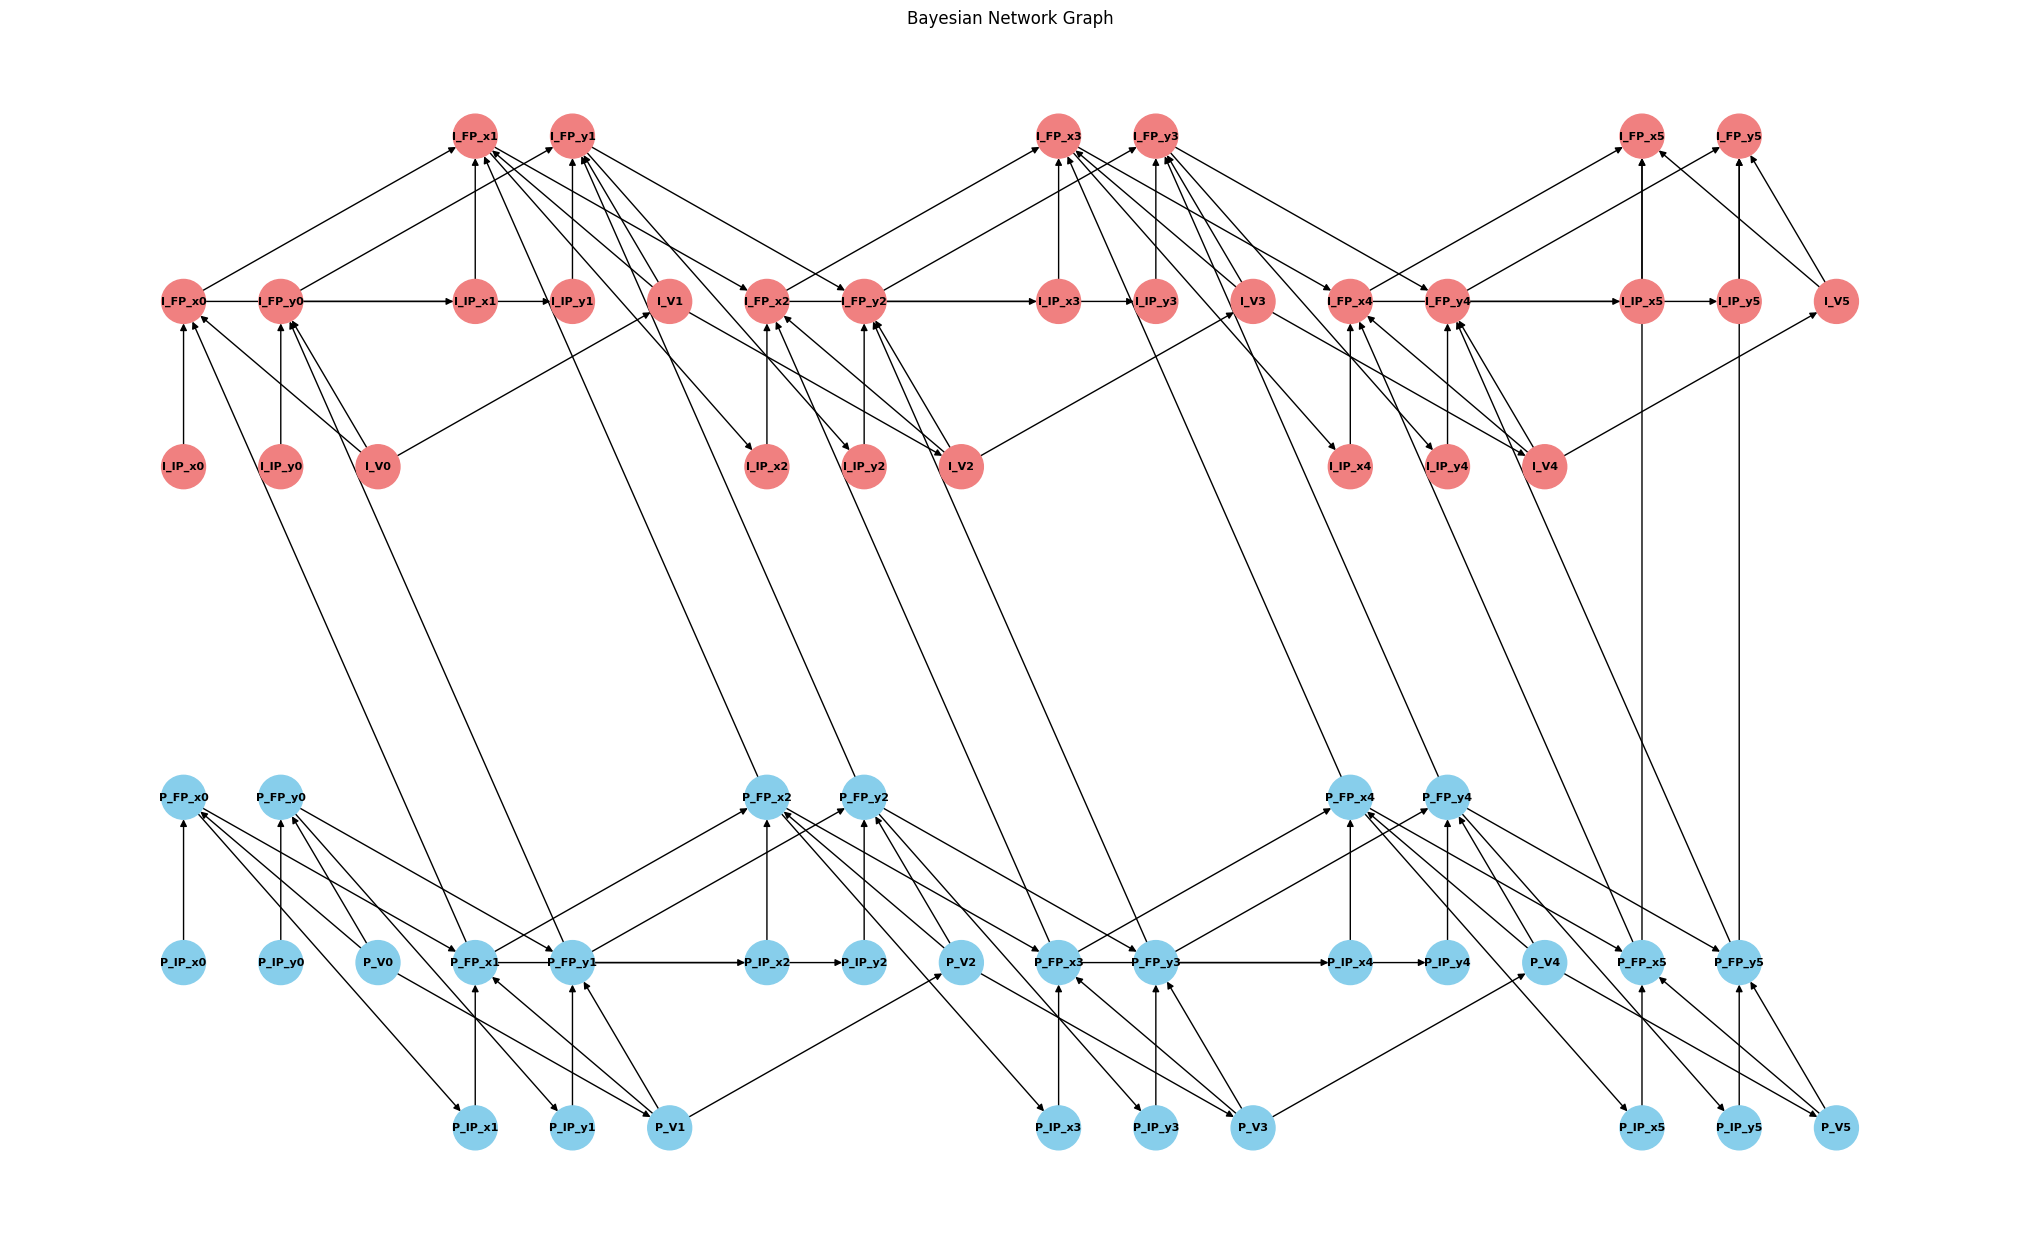

In [12]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    # Add nodes for final position (FP), velocity (V), and initial position (IP)
    GT.add_nodes_from([
        f'P_FP_x{i}', f'P_FP_y{i}', f'P_V{i}', f'P_IP_x{i}', f'P_IP_y{i}',  # Projectile nodes
        f'I_FP_x{i}', f'I_FP_y{i}', f'I_V{i}', f'I_IP_x{i}', f'I_IP_y{i}'   # Interceptor nodes
    ])
    
    # Add edges within each time slice for both x and y positions
    GT.add_edges_from([
        (f'P_IP_x{i}', f'P_FP_x{i}'),  # Initial position (x) influences final position (x)
        (f'P_V{i}', f'P_FP_x{i}'),     # Velocity influences final position (x)
        (f'P_IP_y{i}', f'P_FP_y{i}'),  # Initial position (y) influences final position (y)
        (f'P_V{i}', f'P_FP_y{i}'),     # Velocity influences final position (y)
        
        (f'I_IP_x{i}', f'I_FP_x{i}'),  # Interceptor: Initial position (x) influences final position (x)
        (f'I_V{i}', f'I_FP_x{i}'),     # Velocity influences final position (x)
        (f'I_IP_y{i}', f'I_FP_y{i}'),  # Initial position (y) influences final position (y)
        (f'I_V{i}', f'I_FP_y{i}')      # Velocity influences final position (y)
    ])

    if i < 5:
        # Connect corresponding nodes between time slices for projectile and interceptor
        GT.add_edges_from([
            # Projectile time slice connections for x and y positions
            (f'P_FP_x{i}', f'P_FP_x{i + 1}'),
            (f'P_FP_x{i}', f'P_IP_x{i + 1}'),
            (f'P_FP_y{i}', f'P_FP_y{i + 1}'),
            (f'P_FP_y{i}', f'P_IP_y{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),

            # Interceptor time slice connections for x and y positions
            (f'I_FP_x{i}', f'I_FP_x{i + 1}'),
            (f'I_FP_x{i}', f'I_IP_x{i + 1}'),
            (f'I_FP_y{i}', f'I_FP_y{i + 1}'),
            (f'I_FP_y{i}', f'I_IP_y{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}')
        ])
        
        # Edge between projectile and interceptor across time slices
        GT.add_edges_from([
            (f'P_FP_x{i + 1}', f'I_FP_x{i}'),
            (f'P_FP_y{i + 1}', f'I_FP_y{i}')
        ])

# Final edges to ensure convergence at the last time slice
GT.add_edges_from([
    (f'P_FP_x{5}', f'I_FP_x{5}'),
    (f'P_FP_y{5}', f'I_FP_y{5}')
])

# Visualize the updated Bayesian Network structure
visualise(GT, pos)




In [13]:
def fit_cpd_for_node(node, parents, data):
    required_columns = [node] + parents

    # Ensure all required columns are in the data
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing columns in data: {missing_columns}")
    
    # Creating the correct column names and structure for fitting
    node_data_before = data[required_columns].copy()
    node_data_before.columns = ["(Y|X)" if col == node else col for col in node_data_before.columns]

    # Add noise to all 0.0 values in the DataFrame
    noise_std = 1e-5 
    node_data = node_data_before.map(lambda x: x + np.random.normal(0, noise_std) if x == 0.0 else x)

    print("Fitting CPD for node:", node)
    print("Parents:", parents)
    print("Data being used for fit:")
    print(node_data.head())  # Print the first few rows of node_data

    if parents:
        # Initialize a Linear Gaussian CPD object
        cpd = LinearGaussianCPD(
            variable=node,
            evidence_mean=[0] * (len(parents) + 1),  # Initial guess for betas
            evidence_variance=1,  # Initial variance guess
            evidence=parents
        )
        
        node = "(Y|X)"
        print(f"Node: {node} \n")
        print("-"*50)
        # Fit the CPD using MLE
        beta, variance = cpd.fit(node_data, states=[node] + parents, estimator="MLE")
        return cpd
    else:
        # If no parents, fit a univariate Gaussian
        mean = data[node].mean()
        variance = data[node].var()
        return LinearGaussianCPD(variable=node, evidence_mean=[mean], evidence_variance=variance)




data = pd.read_csv('trajectory_data.csv')

# Assuming you have a pandas DataFrame `data` with all necessary columns.
for i in range(6):
    if i == 0:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [f'P_V{i}', f'P_IP_x{i}'], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [f'P_V{i}', f'P_IP_y{i}'], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [], data)
    else:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [f'P_V{i}', f'P_FP_x{i - 1}', f'P_IP_x{i}'], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [f'P_V{i}', f'P_FP_y{i - 1}', f'P_IP_y{i}'], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [f'P_V{i - 1}'], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [f'P_FP_x{i - 1}'], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [f'P_FP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_P_FP_x, cpd_P_FP_y, cpd_P_V, cpd_P_IP_x, cpd_P_IP_y)

# Fit and add Interceptor CPDs
for i in range(6):
    if i == 0:
        cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_IP_x{i}', f'I_V{i}'], data)
        cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_IP_y{i}', f'I_V{i}'], data)
        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [], data)
    else:
        if i < 4:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_IP_x{i}', f'I_V{i}', f'I_FP_x{i - 1}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_IP_y{i}', f'I_V{i}', f'I_FP_y{i - 1}'], data)
        elif i < 5:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_FP_x{i - 1}', f'I_IP_x{i}', f'I_V{i}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_FP_y{i - 1}', f'I_IP_y{i}', f'I_V{i}'], data)
        else:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'I_FP_x{i - 1}', f'I_IP_x{i}', f'I_V{i}', f'P_FP_x{i}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'I_FP_y{i - 1}', f'I_IP_y{i}', f'I_V{i}', f'P_FP_y{i}'], data)

        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [f'I_V{i - 1}'], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [f'I_FP_x{i - 1}'], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [f'I_FP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_I_FP_x, cpd_I_FP_y, cpd_I_V, cpd_I_IP_x, cpd_I_IP_y)



Fitting CPD for node: P_FP_x0
Parents: ['P_V0', 'P_IP_x0']
Data being used for fit:
         (Y|X)       P_V0       P_IP_x0
0  7943.395469  21.242623   9927.632668
1  7993.393053  24.489528   9988.307293
2  8003.767727  13.355008  10003.699558
3  8075.016019  12.285798  10093.562042
4  8040.169344  23.324704  10051.152498
Node: (Y|X) 

--------------------------------------------------
Fitting CPD for node: P_FP_y0
Parents: ['P_V0', 'P_IP_y0']
Data being used for fit:
      (Y|X)       P_V0       P_IP_y0
0  1.534729  21.242623 -7.995891e-06
1  0.615764  24.489528  3.184038e-06
2 -2.556834  13.355008 -1.082234e-05
3  1.908926  12.285798 -8.309579e-07
4  4.610230  23.324704 -8.510295e-06
Node: (Y|X) 

--------------------------------------------------
Fitting CPD for node: P_V0
Parents: []
Data being used for fit:
       (Y|X)
0  21.242623
1  24.489528
2  13.355008
3  12.285798
4  23.324704
Fitting CPD for node: P_IP_x0
Parents: []
Data being used for fit:
          (Y|X)
0   9927.632668

In [14]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [15]:
import pandas as pd
import numpy as np

# Load the test data
test_data = pd.read_csv("trajectory_test_data.csv")

def predict_with_linear_gaussian_cpd(evidence, cpd):
    """
    Predict values using a Linear Gaussian CPD.
    
    Parameters
    ----------
    evidence: dict
        Dictionary with observed values.
    cpd: LinearGaussianCPD
        The CPD object to use for prediction.
    
    Returns
    -------
    float
        Predicted value for the query variable.
    """
    beta = cpd.beta
    mean_vector = cpd.mean
    variance = cpd.variance
    # print(f"Evidence required: {cpd.evidence}")
    predicted_mean = mean_vector[0] + np.dot(
        [evidence[var] for var in cpd.evidence],
        beta[1:]
    )
    return predicted_mean

# List to store predictions for each row in test_data
predictions = []

# Iterate through each row in the test_data DataFrame
for index, row in test_data.iterrows():
    # Define initial evidence (time slice 0)
    evidence = {
        'P_IP_x0' : row['P_IP_x0'],   
        'P_V0'    : row['P_V0'],   
        'P_IP_y0' : row['P_IP_y0'],   
        'I_IP_x0' : row['I_IP_x0'],   
        'I_V0'    : row['I_V0'],   
        'I_IP_y0' : row['I_IP_y0'],
    }
    
    # Empty dict to store predictions for this row
    row_predictions = {}

    # COMPLETING PREDICTION FOR FIRST TREE

    cpd_x = GT.get_cpds(f'P_FP_x0')
    cpd_y = GT.get_cpds(f'P_FP_y0')
    
    prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
    evidence[f'P_FP_x0'] = prediction_x

    prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
    evidence[f'P_FP_y0'] = prediction_y
    
    row_predictions[f'P_FP_x0'] = prediction_x
    row_predictions[f'P_FP_y0'] = prediction_y
    
    # Propagate predictions for multiple time slices
    for t in range(1,6):
        # Predict for time slice t using evidence from time slice t-1
        cpd_v = GT.get_cpds(f'P_V{t}')
        cpd_I_x = GT.get_cpds(f'P_IP_x{t}')
        cpd_I_y = GT.get_cpds(f'P_IP_y{t}')
        cpd_x = GT.get_cpds(f'P_FP_x{t}')
        cpd_y = GT.get_cpds(f'P_FP_y{t}')
        
        prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
        evidence[f'P_V{t}'] = prediction_v

        prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
        evidence[f'P_IP_x{t}'] = prediction_I_x

        prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
        evidence[f'P_IP_y{t}'] = prediction_I_y

        prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
        evidence[f'P_FP_x{t}'] = prediction_x

        prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
        evidence[f'P_FP_y{t}'] = prediction_y
        
        # Store the predictions for this time slice
        row_predictions[f'P_V{t}'] = prediction_v
        row_predictions[f'P_IP_x{t}'] = prediction_I_x
        row_predictions[f'P_IP_y{t}'] = prediction_I_y
        row_predictions[f'P_FP_x{t}'] = prediction_x
        row_predictions[f'P_FP_y{t}'] = prediction_y

        #INTERCEPTOR NODES
        if t == 1:
            prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
            evidence[f'I_FP_x{t - 1}'] = prediction_x

            prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
            evidence[f'I_FP_y{t - 1}'] = prediction_y

            row_predictions[f'I_FP_x{t - 1}'] = prediction_x
            row_predictions[f'I_FP_y{t - 1}'] = prediction_y
        elif t > 1 and t < 5:

            # Predict for time slice t using evidence from time slice t-1
            cpd_v = GT.get_cpds(f'I_V{t - 1}')
            cpd_I_x = GT.get_cpds(f'I_IP_x{t - 1}')
            cpd_I_y = GT.get_cpds(f'I_IP_y{t - 1}')
            cpd_x = GT.get_cpds(f'I_FP_x{t - 1}')
            cpd_y = GT.get_cpds(f'I_FP_y{t - 1}')
            
            prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
            evidence[f'I_V{t - 1}'] = prediction_v

            prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
            evidence[f'I_IP_x{t - 1}'] = prediction_I_x

            prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
            evidence[f'I_IP_y{t - 1}'] = prediction_I_y

            prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
            evidence[f'I_FP_x{t - 1}'] = prediction_x

            prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
            evidence[f'I_FP_y{t - 1}'] = prediction_y

            
            
            # Store the predictions for this time slice
            row_predictions[f'I_V{t - 1}'] = prediction_v
            row_predictions[f'I_IP_x{t - 1}'] = prediction_I_x
            row_predictions[f'I_IP_y{t - 1}'] = prediction_I_y
            row_predictions[f'I_FP_x{t - 1}'] = prediction_x
            row_predictions[f'I_FP_y{t - 1}'] = prediction_y
        
        else:
            # for the last set of interceptor nodes, when t = 5 then 4 is calculated since I've been using t-1, so for the last t, we do 2 sets of predictions for 4 and then 5
            for i in range (5, 7):
                cpd_v = GT.get_cpds(f'I_V{i - 1}')
                cpd_I_x = GT.get_cpds(f'I_IP_x{i - 1}')
                cpd_I_y = GT.get_cpds(f'I_IP_y{i - 1}')
                cpd_x = GT.get_cpds(f'I_FP_x{i - 1}')
                cpd_y = GT.get_cpds(f'I_FP_y{i - 1}')
                
                prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
                evidence[f'I_V{i - 1}'] = prediction_v

                prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
                evidence[f'I_IP_x{i - 1}'] = prediction_I_x

                prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
                evidence[f'I_IP_y{i - 1}'] = prediction_I_y

                prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
                evidence[f'I_FP_x{i - 1}'] = prediction_x

                prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
                evidence[f'I_FP_y{i - 1}'] = prediction_y

                
                
                # Store the predictions for this time slice
                row_predictions[f'I_V{i - 1}'] = prediction_v
                row_predictions[f'I_IP_x{i - 1}'] = prediction_I_x
                row_predictions[f'I_IP_y{i - 1}'] = prediction_I_y
                row_predictions[f'I_FP_x{i - 1}'] = prediction_x
                row_predictions[f'I_FP_y{i - 1}'] = prediction_y

        
        # Update the evidence with the new predictions to use in the next time slice
        
        
        # evidence[f'I_IP_x{t}'] = row[f'I_IP_x{t}']  # Assuming you also update interceptor evidence
        # evidence[f'I_IP_y{t}'] = row[f'I_IP_y{t}']
        # evidence[f'I_V{t}']    = row[f'I_V{t}']

    # Append predictions for this row
    predictions.append(row_predictions)

# Convert predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame(predictions)

# Print the prediction results
print(predictions_df)


         P_FP_x0   P_FP_y0       P_V1      P_IP_x1   P_IP_y1      P_FP_x1  \
0    8047.385303  2.228760  22.052070  9655.897194  3.110162  7416.037016   
1    7978.617880  1.724446  17.062223  9573.384534  2.406408  7350.254843   
2    8152.830718  2.314873  22.904093  9782.419046  3.230328  7513.492440   
3    7865.849355  2.422172  23.965747  9438.075830  3.380061  7249.953408   
4    7970.462026  1.940451  19.199443  9563.598488  2.707835  7343.822732   
..           ...       ...        ...          ...       ...          ...   
995  7764.388180  2.031333  20.098659  9316.334589  2.834658  7154.650909   
996  7954.004248  2.354419  23.295381  9543.851128  3.285515  7330.734511   
997  8082.398321  2.053773  20.320692  9697.908616  2.865973  7447.385998   
998  8027.433694  2.488648  24.623479  9631.957657  3.472826  7398.968715   
999  7981.398830  2.269234  22.452532  9576.721341  3.166642  7355.519181   

       P_FP_y1      I_FP_x0    I_FP_y0       P_V2  ...       I_V4  \
0    1

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create lists to store the actual and predicted values for comparison
actual_values = []
predicted_values = []

# Define the list of columns that we are interested in for comparison
columns_to_compare = [f'P_V{t}' for t in range(1,6)] + \
                     [f'P_IP_x{t}' for t in range(1,6)] + \
                     [f'P_IP_y{t}' for t in range(1,6)] + \
                     [f'P_FP_x{t}' for t in range(6)] + \
                     [f'P_FP_y{t}' for t in range(6)] + \
                     [f'I_V{t}' for t in range(1,6)] + \
                     [f'I_IP_x{t}' for t in range(1,6)] + \
                     [f'I_IP_y{t}' for t in range(1,6)] + \
                     [f'I_FP_x{t}' for t in range(6)] + \
                     [f'I_FP_y{t}' for t in range(6)] 
                     

# Iterate over each row in the test data
for index, row in test_data.iterrows():
    actual_row = []
    predicted_row = []
    
    # Get actual values for the current row
    for col in columns_to_compare:
        actual_row.append(row[col])
    
    # Get predicted values for the current row from the predictions DataFrame
    predicted_row = [predictions_df.loc[index, col] for col in columns_to_compare]
    print("-" * 50 + f"PREDICTED {index}" + "-" * 50 + '\n')
    print(predicted_row)
    print("")
    print("-" * 50 + f"ACTUAL {index}" + "-" * 50 + '\n')
    print(actual_row)
    print("")

    actual_values.extend(actual_row)
    predicted_values.extend(predicted_row)

# Convert the lists to numpy arrays for metric calculation
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# Calculate accuracy metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

--------------------------------------------------PREDICTED 0--------------------------------------------------

[np.float64(22.052069717314694), np.float64(22.097976076295993), np.float64(21.976210767974745), np.float64(21.8890437372391), np.float64(21.850944563887467), np.float64(9655.897194089213), np.float64(8898.495190360103), np.float64(8201.506019041075), np.float64(7556.008930078944), np.float64(6965.396028655352), np.float64(3.110161515003491), np.float64(15.392555029471369), np.float64(27.867934099927307), np.float64(37.685370722308896), np.float64(46.61543720425485), np.float64(8047.385302607458), np.float64(7416.037016367286), np.float64(6833.147842298478), np.float64(6297.250746587959), np.float64(5804.535226231435), np.float64(5351.392508457031), np.float64(2.228760392411126), np.float64(13.278231491585066), np.float64(23.319986448334127), np.float64(32.289996330679145), np.float64(40.40076608932118), np.float64(47.89378515811358), np.float64(19.020295692346725), np.float